In [22]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model as build_model_probit
from risk_experiment.cogmodels.fit_probit import get_data as get_data_probit
from risk_experiment.cogmodels.fit_model import build_model as build_model
from risk_experiment.cogmodels.fit_model import get_data as get_data

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
from risk_experiment.cogmodels.utils import format_bambi_ppc, cluster_offers, plot_ppc
sns.set_theme('paper', 'white', font='helvetica', font_scale=1.25, palette='tab10')

cm = 1/2.54  # centimeters in inches
bids_folder = '/data/ds-risk'


def load_probit(model_label, session, bids_folder='/data/ds-risk'):
    df = get_data_probit(model_label, session, bids_folder)
    model = build_model_probit(model_label, df, session, bids_folder)
    if session is None:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_trace.netcdf')
    else:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')

    return df, model, idata

def load_model(model_label, session, bids_folder='/data/ds-risk'):
    df = get_data(model_label, session, bids_folder, roi=None)
    model = build_model(model_label, df, roi=None)
    if session is None:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_trace.netcdf')
    else:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/ses-{session}_model-{model_label}_trace.netcdf')

    return df, model, idata

def get_hdi(x):
    return tuple(az.hdi(x.values))

In [16]:
df1, model1, idata1 = load_probit('probit_simple', None)

100%|██████████| 30/30 [00:01<00:00, 21.10it/s]


In [17]:
df2, model2, idata2 = load_model('12', None)

100%|██████████| 30/30 [00:01<00:00, 19.45it/s]


# Plot simpe NLC

Plotting ppc type 2
    risky_first  n_safe  p_predicted    hdi025    hdi975  chose_risky  \
0         False     5.0     0.471785  0.442708  0.498958     0.513542   
1         False     7.0     0.478490  0.453125  0.506250     0.512500   
2         False    10.0     0.486953  0.460417  0.515625     0.558333   
3         False    14.0     0.490493  0.462500  0.519792     0.564583   
4         False    20.0     0.493970  0.466667  0.520833     0.514583   
5         False    28.0     0.496760  0.464583  0.521875     0.482292   
6          True     5.0     0.471259  0.442708  0.498958     0.616667   
7          True     7.0     0.478943  0.451042  0.508333     0.568750   
8          True    10.0     0.486955  0.459375  0.514583     0.442708   
9          True    14.0     0.491344  0.464583  0.518750     0.397917   
10         True    20.0     0.494333  0.464583  0.519792     0.344792   
11         True    28.0     0.496507  0.466667  0.521875     0.325000   

          Order  Safe offer  P

/Users/gdehol/git/risk_experiment/risk_experiment/cogmodels/utils.py:66: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/risk_experiment/risk_experiment/cogmodels/utils.py:241: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/risk_experiment/risk_experiment/cogmodels/utils.py:72: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = df.groupby(groupby).mean()[['chose

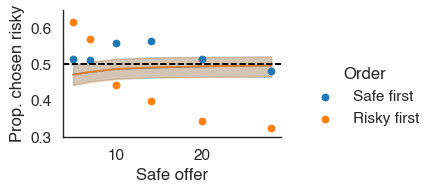

In [52]:
df1['log(risky/safe)'] = df1.groupby(['subject'],
                                        group_keys=False).apply(cluster_offers)
ppc1 = format_bambi_ppc(idata1, model1, df1)

fig = plot_ppc(df1, ppc1, level='group', plot_type=2, var_name='ll_bernoulli')
fig.set(ylim=(.3, .65))
fig.figure.set_size_inches(5, 1.75)

plt.savefig('/data/ds-risk/derivatives/figures/ppc_simple_nlc.pdf', bbox_inches='tight')

# Plot complex NLC

In [43]:
df2.drop('session', 1)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_91489/3807650696.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2.drop('session', 1)


rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      3t2     1   1         1.096017          1.0      -1.508735   
                    2         1.324627          1.0      -1.508735   
                    3         1.224786          3.0       0.997077   
                    4         1.125724          3.0       0.997077   
                    5         1.175374          3.0       0.997077   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob1  \
subject session run trial_nr                                               
02      3t2     1   1                 low uncertainty   5.0   5.0   0.55   
                    2                 low uncertainty   7.0   7.0   0.55   
                    3                high uncertainty  37.0  20.0   0.55   
                    4                high uncertainty  47.0  20.0   0.55   
                    5                high uncertainty  18.0  10.0   0.55   
...                                               ...   ...   ...    ...   
32      7t2     8   188               low uncertainty  26.0  10.0   0.55   
                    189              high uncertainty  15.0   7.0   0.55   
                    190               low uncertainty  34.0  28.0   0.55   
                    191               low uncertainty  34.0  28.0   0.55   
                    192              high uncertainty  28.0   7.0   0.55   

                              prob2    p1   p2  ...  choice  risky_first  \
subject session run trial_nr                    ...                        
02      3t2     1   1           1.0  0.55  1.0  ...    True         True   
                    2           1.0  0.55  1.0  ...    True         True   
                    3           1.0  0.55  1.0  ...    True         True   
                    4           1.0  0.55  1.0  ...   False         True   
                    5           1.0  0.55  1.0  ...    True         True   
...                             ...   ...  ...  ...     ...          ...   
32      7t2     8   188         1.0  0.55  1.0  ...    True         True   
                    189         1.0  0.55  1.0  ...    True         True   
                    190         1.0  0.55  1.0  ...    True         True   
                    191         1.0  0.55  1.0  ...    True         True   
                    192         1.0  0.55  1.0  ...    True         True   

                              chose_risky        Order  n_risky  n_safe  \
subject session run trial_nr                                              
02      3t2     1   1               False  Risky first      5.0     5.0   
                    2               False  Risky first      7.0     7.0   
                    3               False  Risky first     37.0    20.0   
                    4                True  Risky first     47.0    20.0   
                    5               False  Risky first     18.0    10.0   
...                                   ...          ...      ...     ...   
32      7t2     8   188             False  Risky first     26.0    10.0   
                    189             False  Risky first     15.0     7.0   
                    190             False  Risky first     34.0    28.0   
                    191             False  Risky first     34.0    28.0   
                    192             False  Risky first     28.0     7.0   

                                  frac  log(risky/safe)  bin(risky/safe)  \
subject session run trial_nr                                               
02      3t2     1  

In [46]:
ppc2 = model2.ppc(trace=idata2.sel(draw=slice(None, None, 10)), data=df2.drop('session', axis=1))

# "Chose risky" vs "chose 2nd option coding"
ppc2.loc[ppc2.index.get_level_values('risky_first')] = 1 - ppc2.loc[ppc2.index.get_level_values('risky_first')]

<Figure size 640x480 with 0 Axes>

Plotting ppc type 2
    risky_first  n_safe  p_predicted    hdi025    hdi975  chose_risky  \
0         False     5.0     0.519306  0.490625  0.551042     0.513542   
1         False     7.0     0.521128  0.491667  0.548958     0.512500   
2         False    10.0     0.522674  0.494792  0.545833     0.558333   
3         False    14.0     0.518941  0.493750  0.542708     0.564583   
4         False    20.0     0.512918  0.487500  0.538542     0.514583   
5         False    28.0     0.507382  0.477083  0.534375     0.482292   
6          True     5.0     0.605542  0.573958  0.636458     0.616667   
7          True     7.0     0.547748  0.521875  0.577083     0.568750   
8          True    10.0     0.478148  0.450000  0.502083     0.442708   
9          True    14.0     0.411401  0.384375  0.438542     0.397917   
10         True    20.0     0.348693  0.321875  0.375000     0.344792   
11         True    28.0     0.304844  0.276042  0.328125     0.325000   

          Order  Safe offer  P

/Users/gdehol/git/risk_experiment/risk_experiment/cogmodels/utils.py:66: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/risk_experiment/risk_experiment/cogmodels/utils.py:241: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/risk_experiment/risk_experiment/cogmodels/utils.py:72: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = df.groupby(groupby).mean()[['chose

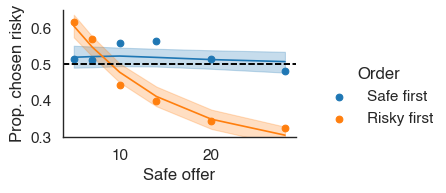

In [53]:
fig = plot_ppc(df2, ppc2, level='group', plot_type=2, var_name='ll_bernoulli')
fig.figure.set_size_inches(5, 1.75)
fig.set(ylim=(.3, .65))
plt.savefig('/data/ds-risk/derivatives/figures/ppc_extended_nlc.pdf', bbox_inches='tight')